In [1]:
import glob
import random
from typing import Callable, Optional, List

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import pyplot as plt
from scipy.spatial import distance as distance_calculator
import torch
from torch import Tensor
from torch_geometric import nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.utils import scatter
import seaborn as sn
from torch.nn import Sequential as Seq, Linear as Lin, Dropout, ReLU, BatchNorm1d as BN
from torch_geometric.nn.conv import MessagePassing
from torch_multi_head_attention import MultiHeadAttention
import time

#### Loading the data
In each files, the frame numbers are shifted to come after the largest frame number in the previous file. This way all frame numbers are unique.

The dataset contains frames of 1 to 5 people.


In [2]:
random.seed(42)
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq']

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.zeros(len(features1), dtype=int), True)
max_frame = max(features1["current_frame"])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 1, dtype=int), True)
min_frame = min(features2["current_frame"])
shift = max_frame-min_frame+10
features2["current_frame"] += shift
max_frame = max(features2["current_frame"])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 2, dtype=int), True)
min_frame = min(features3["current_frame"])
shift = max_frame-min_frame+10
features3["current_frame"] += shift
max_frame = max(features3["current_frame"])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 3, dtype=int), True)
min_frame = min(features4["current_frame"])
shift = max_frame-min_frame+10
features4["current_frame"] += shift
max_frame = max(features4["current_frame"])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 4, dtype=int), True)
min_frame = min(features5["current_frame"])
shift = max_frame-min_frame+10
features5["current_frame"] += shift
max_frame = max(features5["current_frame"])

features_bikes: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/bikes/bikes/*.csv")])
features_bikes.insert(8, "Label", np.full(len(features_bikes), 5, dtype=int), True)
min_frame = min(features_bikes["current_frame"])
shift = max_frame-min_frame+10
features_bikes["current_frame"] += shift
max_frame = max(features_bikes["current_frame"])

all_data = pd.concat([features1, features2, features3, features4, features5, features_bikes])
all_data.drop_duplicates(subset=['range','azimuth','doppler','snr','y','x','current_frame','Label'], inplace=True, ignore_index=True)
print("Number of data points: "+str(len(all_data)))

# group the data by frame numbers
all_data_grouped = all_data.groupby("current_frame")
print("Largest frame number: "+str(max_frame))
print("Total number of frames: "+str(len(all_data_grouped)))

Number of data points: 1316527
Largest frame number: 87079187.0
Total number of frames: 23238


#### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reduced_cols = ['doppler','snr','x','y','current_frame','Label']
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq', 'Label']
selected_cols = ['doppler','snr','x','y']
SHAPE_NAMES = [0,1,2,3,4, 5]
frame_depths = [5] 
ks = [6]
num_chunks = 16
lr = 0.001
max_epoch = 100
EARLY_STOPPING_PATIENCE = 15
train, val, test =[],[],[]

/home/detti/research-project/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
print(device)

cpu



#### Utils

In [5]:
def split_with_chunks(data_array: List[DataFrame], labels: List[int], num_chunks:int, val_frac:float, test_frac:float):
    """
    Divides the dataset into train, test and validition sets. 
    This done by dividing each label's data into n chunks 
    and from each chunk the last val_frac and test_frac amount is moved to validation and test sets.

    :param data_array: The array containing the data
    :param labels: The labels found in the dataset
    :param num_chunks: The number of chunks to divide the data to
    :param val_frac: Fraction of validation set size (between 0 and 1)
    :param test_frac: Fraction of test set size (between 0 and 1)
    :return: The train, validation and test set
    """
    train_frac = 1 - val_frac - test_frac
    train = []
    test = []
    val =[]
    label_values = np.array([data.iloc[0,5] for data in data_array])

    for label in labels:
        itemindex = np.where(label_values == label)
        frames = [data_array[i] for i in itemindex[0]]
        chunk_size = int(len(frames) / num_chunks)
        chunk_indexes = [i*chunk_size for i in range(num_chunks)]
        chunk_indexes.append(len(frames))

        for chunk in range(num_chunks):
            data_chunk = frames[chunk_indexes[chunk] : chunk_indexes[chunk+1]]
            train.extend(data_chunk[:int(train_frac * len(data_chunk))])
            val.extend(data_chunk[int(train_frac * len(data_chunk)):int((train_frac + val_frac) * len(data_chunk))])
            test.extend(data_chunk[int((train_frac + val_frac) * len(data_chunk)):])

    assert len(train)+len(val)+len(test) == len(data_array)
    return train, val, test



In [6]:
def min_max_normalization(frames:List[DataFrame], selected_cols:List[str]):
    """
    Normalizes the data by appliying min-max normalization on each feature given in 'selected_cols'.

    :param frames: The dataset to normalize
    :param selected_cols: The names of the columns to normalize
    :return: The normalized features together with the sequence numbers and labels.
    """
    min_max = [(data[selected_cols].min(), data[selected_cols].max()) for data in frames]
    min_dict = min_max[0][0]
    max_dict = min_max[0][1]
    for mm in min_max[1:]:
        for key, value in mm[0].items():
            min_dict[key] = min(min_dict[key], value)
        for key, value in mm[1].items():
            max_dict[key] = max(max_dict[key], value)

    normalized_frames = [(frames[i][selected_cols]-min_dict)/(max_dict-min_dict) for i in range(len(frames))]
    normalized_frames = [pd.concat([normalized_frames[i], frame[['current_frame','Label']]], axis=1) for i, frame in enumerate(frames)]
    return normalized_frames

def connect_frames(current_frame:List[np.array], next_frame:List[np.array], k: int, start_index: int, descending:bool = True):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param next_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: The values (euclidean distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph. 
            It also returns a boolean indicating whether the creation was successful or not.
    """
    edges = []
    adjacency_list = []
    current_nodes = np.arange(start_index, start_index+len(current_frame)) 
    next_nodes = np.arange(start_index+len(current_frame), start_index+len(current_frame)+len(next_frame))
    distances_all  = distance_calculator.cdist(current_frame, next_frame, 'euclidean')
    for i in range(len(current_frame)):
        distances = distances_all[i]
        if descending:
            idx = distances.argsort()[::-1]
        else:
            idx = distances.argsort()
        distances = distances[idx]
        ordered_next_nodes = next_nodes[idx]
        if len(distances) < k:
            return [], [], False
        
        edges.extend(distances[:k])
        for j in range(k):
            adjacency_list.append((current_nodes[i], ordered_next_nodes[j]))
    return edges, adjacency_list, True

def create_graph_list_with_overlap(frames:List[DataFrame], selected_cols:List[str], device:str,
                                   k:int = 3, frame_depth:int = 2, descending:bool = True):
    """
    Creates a list of Data objects that represents the graphs built from the input data. 
    The edges in the graph connects the frames to the previous frame by connecting each 
    points in a frame to it's nearest/furthest neighbour in the previous frame. 
    The nodes contain information about the selected columns. 
    The edges store information about the eucledian distance between the points.
    
    :param frames: Input data grouped and sorted by the frame number
    :param device: The device to store the graphs on (cuda or cpu)
    :param selected_cols: The names of the columns to make nodes out of
    :param k: The number of neighbours to connect each points to
    :param frame_depth: The depth of the graph (number of previos nodes)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: A list of Data objects, containing information about the created graphs
    """
    if len(frames) == 0:
        return []
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = [rf[selected_cols] for rf in relevant_frames]
        # time_distance = relevant_frames[-1].iloc[0, 4] - relevant_frames[0].iloc[0, 4]

        # only make graphs if the gap between any two frames is at most 6 and all frames have the same label
        frame_diff = [relevant_frames[i+1].iloc[0, 4] - relevant_frames[i].iloc[0, 4] for i in range(frame_depth)]
        if max(frame_diff) > 6 or relevant_frames[-1].iloc[0, 5] != relevant_frames[0].iloc[0, 5]:
            continue

        point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        for depth in range(frame_depth):
            #calculate the distance for the edges based on the x and y coordinates
            pairwise_edges, pairwise_adjacency_list, success = \
                connect_frames(point_data_array[frame_depth-depth][:,2:4], point_data_array[frame_depth-depth-1][:,2:4], k, start_index, descending)
            if not success:
                break
            start_index += len(relevant_frames[frame_depth-depth])
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[frame_depth-depth])
        if not success:
                continue
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        
        graphs.append(Data(x=torch.tensor(np.array(nodes), dtype=torch.float, device=device), 
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float, device=device),
                    y=torch.tensor(int(label), dtype=torch.int64, device=device)))
    return graphs

In [7]:
def load_graphs(train:List[DataFrame], val:List[DataFrame], test:List[DataFrame], 
                frame_depths:List[int], ks:List[int], selected_cols:List[str], device:str, descending):
    """
    Loads the graphs if already saved or creates them if not yet saved.

    :param train: The frames in the train set
    :param val: The frames in the validation set
    :param test: The frames in the test set
    :param frame_depths: The depths of the graph (number of previos nodes)
    :param ks: The number of neighbours to connect each points to
    :param selected_cols: The names of the columns to make nodes out of
    :param device: The device to store the graphs on (cuda or cpu)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: The graphs created from the train, validation and test sets
    """
    graph_sets = []
    for i, data_set in enumerate([train, val, test]):
        generated_graphs = []
        for f in frame_depths:
            for k in ks:
                # try:
                #     graphs = torch.load(f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}_max{descending}.pt")
                #     print("File read")
                # except Exception as e:
                graphs = create_graph_list_with_overlap(data_set, selected_cols, device, k=k, frame_depth=f)
                    # torch.save(graphs, f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}_max{descending}.pt")
                
                print(f"Number of graphs generated with k = {k} and frame depth = {f} for type {i}: {len(graphs)}")
                generated_graphs.append(graphs)
        graph_sets.append(generated_graphs)
    
    return graph_sets[0], graph_sets[1], graph_sets[2]

#### Pre-processing pipeline

In [8]:
# This cell can be skipped if all graps are saved in files

data_array = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")
# Sort the data
sorted_data = sorted(data_array,key=lambda x:x["current_frame"].max(axis=0))
# Normalize the data
norm_frames = min_max_normalization(sorted_data, selected_cols)
# Split the data
train, val, test = split_with_chunks(norm_frames, SHAPE_NAMES, num_chunks, 0.15, 0.15)

In [9]:
# Create graphs for each sets with each hyperparameter combination
train_graphs, val_graphs, test_graphs = load_graphs(train, val, test, frame_depths, ks, selected_cols, device, descending=True)

train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Batch the sets
for i in range(len(train_graphs)):
    random.seed(42)
    random.shuffle(train_graphs[i])
    random.seed(42)
    random.shuffle(test_graphs[i])
    random.seed(42)
    random.shuffle(val_graphs[i])
    
    train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))


Number of graphs generated with k = 6 and frame depth = 5 for type 0: 6111
Number of graphs generated with k = 6 and frame depth = 5 for type 1: 1190
Number of graphs generated with k = 6 and frame depth = 5 for type 2: 1209


#### Graph Neural Network

In [10]:
def MLP(channels):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)
            
class GeneralizedTemporalSelfAttentionDynamicEdgeConv(MessagePassing):
    def __init__(self, nn: Callable, 
                 attention_in_features: int,
                 k: int,
                 aggr: str = 'mean',
                 **kwargs):
        
        super(GeneralizedTemporalSelfAttentionDynamicEdgeConv,
              self).__init__(aggr=aggr, flow='source_to_target', **kwargs)

        self.nn = nn
        self.multihead_attn = MultiHeadAttention(attention_in_features, 8)
        self.k = k
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.multihead_attn)
        reset(self.nn)

    def forward(self, x, data) -> Tensor:
        return self.propagate(data.edge_index, x=x, edge_attr=data.edge_attr, size=None, batch=data.batch)

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr) -> Tensor:
        msg = torch.cat([x_j, x_i - x_j, torch.reshape(edge_attr, (len(edge_attr),1))], dim=-1)
        return self.nn(msg)

    def aggregate(self, inputs: Tensor, index: Tensor,
                  dim_size: Optional[int] = None) -> Tensor:
        original_shape = inputs.shape
        attention_input_shape = list([int(original_shape[0] / self.k)]) + list(original_shape)
        attention_input_shape[1] = self.k
        self_attention_input = inputs.reshape(attention_input_shape)
        attn_output = self.multihead_attn(self_attention_input, self_attention_input, self_attention_input)
        attn_output = attn_output.reshape(original_shape)
        # Apply attention mechanism
        return scatter(attn_output, index, dim=self.node_dim, dim_size=dim_size,
                       reduce=self.aggr)


In [11]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, k=3, aggr='mean'):
        super().__init__()
        self.aggr = aggr

        self.conv1 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2*4 +1, 64, 64, 64]),
                                                                     attention_in_features=64, 
                                                                     k=k, 
                                                                     aggr=aggr)

        self.lin1 = MLP([64, 1024])

        self.mlp = Seq(
            MLP([1024, 512]), #Dropout(0.5), MLP([1024, 512]), Dropout(0.5), MLP([512, 512]),  
            Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        x1 = self.conv1(data.x, data)
        out = self.lin1(x1)
        
        out = scatter(src=out, index=data.batch, dim=0, reduce=self.aggr)
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

#### Train the model

In [12]:
# model_losses = []
# model_accuracies = []
models = []

for i, train_dataloader in enumerate(train_dataloaders):
    val_accuracies = []
    start_time = time.time()
    k = ks[i % len(ks)]
    model = Net(6, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = -1
    losses = []
    accuracies = []
    for epoch in range(max_epoch):
        correct = 0
        count = 0
        model.train()
        for train_batch in train_dataloader:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            out = model(train_batch)
            pred = out.argmax(dim=1)
            correct += (pred == train_batch.y).sum()
            loss = F.nll_loss(out, train_batch.y)
            losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            count += len(train_batch)
        acc = int(correct) / count
        losses.append(loss.detach())
        accuracies.append(acc)
        scheduler.step()

        model.eval()
        val_correct = 0
        for val_batch in val_dataloaders[i]:
            val_batch = val_batch.to(device)
            pred = model(val_batch).argmax(dim=1)
            
            val_correct += (pred == val_batch.y).sum()
        val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_acc_epoch = epoch
            last_improvement = 0
        else:
            last_improvement += 1

        if last_improvement > EARLY_STOPPING_PATIENCE:
            break
    
    models.append(model)
    torch.save(model, f"data/trained_model_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_extended_chunk{num_chunks}.pt")
    losses = [tensor.cpu().numpy() for tensor in losses]
    # model_losses.append(losses)
    # model_accuracies.append(accuracies)
    print(f"trained: {i}")

    plt.plot(accuracies, label = "train")
    plt.plot(val_accuracies, label = "validation")
    plt.title(f"Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.ylim(0,1)
    plt.legend() 
    plt.show()

    plt.plot(losses)
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

    print("Training accuracy: "+str(accuracies[-1]))
    print("Training loss: "+str(losses[-1]))
    
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {val_accuracies[-1]:.4f}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print(f"evaluated: {i}")

KeyboardInterrupt: 

#### Evaluate the model on the test set

In [16]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for val_batch in test_dataloaders[i]:
    val_batch = val_batch.to(device)
    pred = model(val_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(test_graphs[i])
val_accuracies.append(acc)
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 8 and frame depth = 3: 0.7691


#### Confusion matrix

Text(0.5, 14.722222222222216, 'Predicated Label')

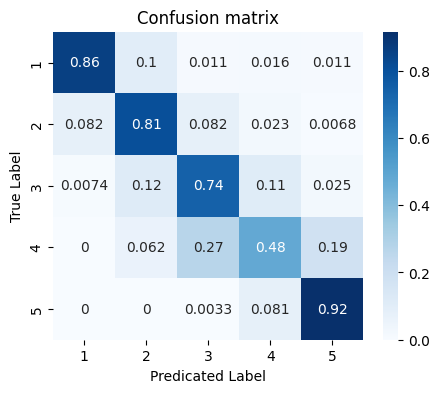

In [17]:
SHAPE_LABELS = [1,2,3,4,5,"bikes"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

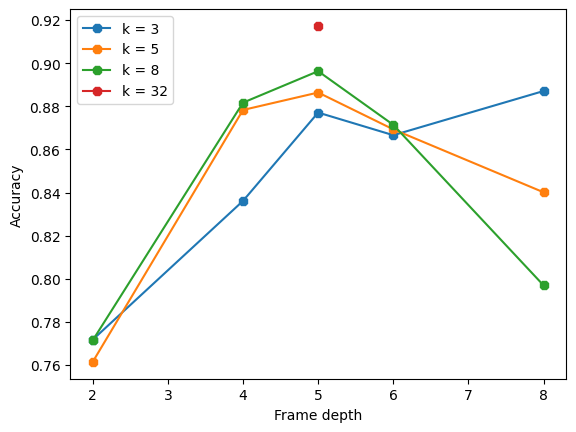

In [11]:
accuracies = np.array([0.7717, 0.7614, 0.7714,0.8361,0.8783,0.8817,0.8771,0.8864, 0.8963, 0.8666,0.8693,0.8714,0.8871,0.8401,0.7969])

frame_depths = [2,4,5,6,8]
ks =[3,5,8]
plt.plot(frame_depths, accuracies[[i*len(ks) for i in range(len(frame_depths))]], label = "k = 3", marker="8") 
plt.plot(frame_depths, accuracies[[i*len(ks)+1 for i in range(len(frame_depths))]], label = "k = 5", marker="8") 
plt.plot(frame_depths, accuracies[[i*len(ks)+2 for i in range(len(frame_depths))]], label = "k = 8", marker="8") 
plt.plot(5, 0.9173, label = "k = 32", marker="8") 
plt.xlabel("Frame depth")
plt.ylabel("Accuracy")
plt.legend() 
plt.show()

#### Distribution of the train data

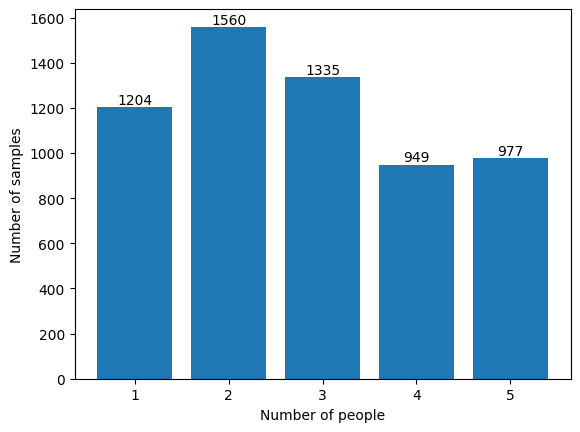

In [14]:
data_points = np.array([d.y.item() for d in train_graps[0]])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])

labels = [1,2,3,4,5]
sample_num = [zeros, ones, twos, threes, fours]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()